## Import libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Install and login to W&B for tracking

In [2]:
%%capture
!pip install wandb

In [3]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Download Preprocessed Dataset

In [4]:
!wget -O /content/Data_Sorted_all.txt https://github.com/CristianMaza/Handwritten-Signature-Verification-sCNN/raw/main/Data_Sorted_all.txt

--2022-12-16 23:55:02--  https://github.com/CristianMaza/Handwritten-Signature-Verification-sCNN/raw/main/Data_Sorted_all.txt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/CristianMaza/Handwritten-Signature-Verification-sCNN/main/Data_Sorted_all.txt [following]
--2022-12-16 23:55:02--  https://media.githubusercontent.com/media/CristianMaza/Handwritten-Signature-Verification-sCNN/main/Data_Sorted_all.txt
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47622300 (45M) [text/plain]
Saving to: ‘/content/Data_Sorted_all.txt’

/content/Data_Sorte 100%[===================>]  45.42M   2

In [5]:
all_xy = np.loadtxt("/content/Data_Sorted_all.txt", usecols=range((128*64)+1), delimiter="\t", comments="#", dtype=np.float32)
images = all_xy[:, 0:64*128]  
images /= 255
labels = all_xy[:, 64*128]

In [6]:
signature_types = 2 # Genuine & Forgery
num_users = 55 # Number of users
total_samples = 24    # 24 samples per class
distribution_rate = 0.7   # 70% for training - 30% for testing

total_classes = num_users*signature_types
train_dist_rate = round(distribution_rate*total_samples)
BATCH_SIZE = 64

train_images = images[0:total_classes*train_dist_rate].reshape(-1, 64, 128, 1)
test_images = images[total_classes*train_dist_rate:].reshape(-1, 64, 128, 1)
train_labels = labels[0:total_classes*train_dist_rate]
test_labels = labels[total_classes*train_dist_rate:]

# build input pipeline using tf.data
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
val_dataset = val_dataset.batch(BATCH_SIZE)

## Define the Model and the Training loop

In [7]:
def make_model():
    inputs = keras.Input(shape=(64,128,1), name="digits")
    conv1 = keras.layers.Conv2D(40, (7, 7), activation='relu', input_shape=(64, 128, 1))(inputs)
    pool1 = keras.layers.MaxPooling2D((2, 2))(conv1)
    conv2 = keras.layers.Conv2D(30, (5, 5), activation='relu')(pool1)
    pool2 = keras.layers.MaxPooling2D((3, 3))(conv2)
    conv3 = keras.layers.Conv2D(20, (3, 3), activation='relu')(pool2)
    pool3 = keras.layers.MaxPooling2D((3, 3))(conv3)
    flat = keras.layers.Flatten()(pool3)
    dense1 = keras.layers.Dense(((total_classes)*2)+2, activation="relu")(flat) # last parameter is for dimensions, "+2" for a 2D image
    outputs = keras.layers.Dense(total_classes, activation="softmax", name="predictions")(dense1)

    return keras.Model(inputs=inputs, outputs=outputs)
def train_step(x, y, model, optimizer, loss_fn, train_acc_metric):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    train_acc_metric.update_state(y, logits)

    return loss_value
def test_step(x, y, model, loss_fn, val_acc_metric):
    val_logits = model(x, training=False)
    loss_value = loss_fn(y, val_logits)
    val_acc_metric.update_state(y, val_logits)

    return loss_value

### Define training loop and add `wandb.log` to it

In [8]:
def train(train_dataset, val_dataset,  model, optimizer,
          train_acc_metric, val_acc_metric,
          epochs=10,  log_step=200, val_log_step=50):
  
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))

        train_loss = []   
        val_loss = []

        # Iterate over the batches of the dataset
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            loss_value = train_step(x_batch_train, y_batch_train, 
                                    model, optimizer, 
                                    loss_fn, train_acc_metric)
            train_loss.append(float(loss_value))

        # Run a validation loop at the end of each epoch
        for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
            val_loss_value = test_step(x_batch_val, y_batch_val, 
                                       model, loss_fn, 
                                       val_acc_metric)
            val_loss.append(float(val_loss_value))
            
        # Display metrics at the end of each epoch
        train_acc = train_acc_metric.result()
        print("Training acc over epoch: %.4f" % (float(train_acc),))

        val_acc = val_acc_metric.result()
        print("Validation acc: %.4f" % (float(val_acc),))

        # Reset metrics at the end of each epoch
        train_acc_metric.reset_states()
        val_acc_metric.reset_states()

        # ⭐: log metrics using wandb.log
        wandb.log({'epochs': epoch,
                   'loss': np.mean(train_loss),
                   'acc': float(train_acc), 
                   'val_loss': np.mean(val_loss),
                   'val_acc':float(val_acc)})

## Define FAR & FRR functions

#### FAR (False Acceptance Rate)
Cantidad de firmas falsificadas que son aceptadas como genuinas

$FAR_{skilled}$ = Considera únicamente firmas falsificadas hábiles

In [9]:
def find_far(model, num_users, verbose=0):
  far_prob = []
  for idx in range(len(test_images)):
    if test_labels[idx]>num_users-1: # Taking forgeries only
      q = model.predict(np.array([test_images[idx]]), verbose = 0)
      far_prob.append(q[0][int((test_labels[idx]-num_users))]*100) 
  far = []
  threshold = []
  for i in range(100): #Threshold from 0 to 99%
    num = 0
    for x in far_prob:
      if x>i:
        num+=1
    far.append(num*(100/len(far_prob))) #percentaje
    threshold.append(i)
  far = np.array(far)
  return far

####FRR (False Rejection Rate)
Cantidad de firmas genuinas que se rechazan (no son aceptadas como genuinas por el sistema) 

In [10]:
def find_frr(model, num_users, verbose=0):
  frr_prob = []
  for idx in range(len(test_images)): 
    if test_labels[idx]<num_users: # Taking genuine signatures only
      q = model.predict(np.array([test_images[idx]]),verbose = 0)
      id = np.where(q == max(q[0]))
      if test_labels[idx] == int(id[1][0]):
        frr_prob.append(q[0][int(test_labels[idx])]*100)
  frr = []
  for i in range(100):
    num = 0
    for prob in frr_prob:
      if prob<i:
        num+=1
    frr.append(num*(200/len(test_images)))
  frr = np.array(frr)
  return frr

## Run Training

In [17]:
# initialize wandb with your project name and optionally with configutations.
# play around with the config values and see the result on your wandb dashboard.
config = {
              "learning_rate": 0.005,
              "epochs": 20,
              "batch_size": 32,
              "log_step": 20,
              "val_log_step": 50,
              "architecture": "sCNN",
              "dataset": f"CEDAR:{distribution_rate*100}%_{signature_types}types"
           }

run = wandb.init(project='signatures', config=config)
config = wandb.config

# Initialize model.
model = make_model()

# Instantiate an optimizer to train the model.
optimizer = keras.optimizers.Adam(learning_rate=config.learning_rate)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

train(train_dataset,
      val_dataset, 
      model,
      optimizer,
      train_acc_metric,
      val_acc_metric,
      epochs=config.epochs, 
      log_step=config.log_step, 
      val_log_step=config.val_log_step)
print("\nCalculating FRR...")
frr = find_frr(model, num_users)
data_frr = [[i, frr[i]] for i in range(len(frr))]
print("\nCalculating FAR...")
far = find_far(model, num_users)
data_far = [[i, far[i]] for i in range(len(far))]
print("\nCalculating ERR...")
EER = 100
# calculate the EER
idx = np.argwhere(np.diff(np.sign(far - frr))).flatten()[-1]
EER = frr[idx]

# Create a table with the columns to plot
table_frr = wandb.Table(data=data_frr, columns=["Threshold (%)", "Genuine signatures rejected (%)"])
table_far = wandb.Table(data=data_far, columns=["Threshold (%)", "Forgeries accepted (%)"])
# Use the table to populate various custom charts
line_plot_frr = wandb.plot.line(table_frr, x='Threshold (%)', y='Genuine signatures rejected (%)', title='FRR')
line_plot_far = wandb.plot.line(table_far, x='Threshold (%)', y='Forgeries accepted (%)', title='FAR')
line_series = wandb.plot.line_series(xs=[i for i in range(len(frr))], ys=[frr, far], keys=["FRR", "FAR"], title='EER', xname="Threshold (%)")

# Log custom tables, which will show up in customizable charts in the UI
wandb.log({'line_1': line_plot_frr,
           'line_2': line_plot_far,
           'line_3': line_series,
           'EER': EER})

run.finish()  # In Jupyter/Colab, let us know you're finished!


Start of epoch 0
Training acc over epoch: 0.0080
Validation acc: 0.0377

Start of epoch 1
Training acc over epoch: 0.1134
Validation acc: 0.2506

Start of epoch 2
Training acc over epoch: 0.4850
Validation acc: 0.6130

Start of epoch 3
Training acc over epoch: 0.7283
Validation acc: 0.6844

Start of epoch 4
Training acc over epoch: 0.8299
Validation acc: 0.6844

Start of epoch 5
Training acc over epoch: 0.9053
Validation acc: 0.7481

Start of epoch 6
Training acc over epoch: 0.9193
Validation acc: 0.7390

Start of epoch 7
Training acc over epoch: 0.9118
Validation acc: 0.7221

Start of epoch 8
Training acc over epoch: 0.9508
Validation acc: 0.7455

Start of epoch 9
Training acc over epoch: 0.9797
Validation acc: 0.7506

Start of epoch 10
Training acc over epoch: 0.9717
Validation acc: 0.7519

Start of epoch 11
Training acc over epoch: 0.9818
Validation acc: 0.7935

Start of epoch 12
Training acc over epoch: 0.9797
Validation acc: 0.7688

Start of epoch 13
Training acc over epoch: 0.95

EER,▁
acc,▁▂▄▆▇▇█▇████████████
epochs,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▆▇▇█▇▇████████████
val_loss,█▅▂▁▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁
EER,3.8961
acc,0.98877
epochs,19
loss,0.03404
val_acc,0.76753


## Evaluate the model

In [53]:
# Grab sample from  set.
user_input = 51 # what user you wanna test?
isGenuine = False # wanna use a gennuine or forgery sample?

useID = True # Use ID?
# True = use User ID to verify if signature is genuine or forgery
# False = Identify user and verify if signature is genuine or forgery

Input: User #51 - Forgery


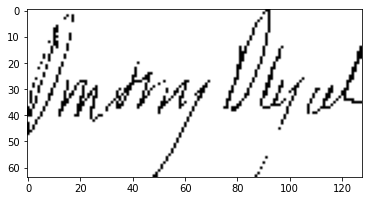

Output: 
User: #51
Signature: Forgery
Accuracy: 98.86%


In [56]:

if isGenuine:
  num = (51-1)*2
else:
  num = (51-1)*2+1

test_image = test_images[num]
if test_labels[num]<num_users:
  print(f"Input: User #{int(test_labels[num])+1} - Genuine")
else:
  print(f"Input: User #{int((test_labels[num]-num_users))+1} - Forgery")
q = model.predict(np.array([test_image]),verbose = 0)
id = q[0][user_input-1]
id = np.where(q == max(q[0]))

# Display image and model prediction.
plt.imshow(np.reshape(test_image, [64, 128]), cmap='gray_r')
plt.show()

if useID:
  if q[0][user_input-1] > q[0][user_input-1+num_users]:
    print(f"Output: User # {user_input} - Genuine")
    print(f"Accuracy: {round(q[0][user_input-1]*100, 2)}%")
  else:
    print(f"Output: User # {user_input} - Forgery")
    print(f"Accuracy: {round(q[0][user_input-1+num_users]*100, 2)}%")
else:
  user_pred = id[1][0]
  isForgery = False
  if (user_pred)>=num_users:
    isForgery = True
    user_pred = user_pred-num_users
  print(f"Output: \nUser: #{user_pred+1}")
  if max(q[0])>=0.67:
    if isForgery:
      print(f"Signature: Forgery")
    else:
      print(f"Signature: Genuine")
  else:
    print(f"Signature: Forgery")
  print(f"Accuracy: {round(max(q[0])*100, 2)}%")

## Save/Load model to GDrive

In [13]:
# Sign in
from google.colab import drive
drive.flush_and_unmount()
drive.mount("/content/drive")
!ln -s /content/drive/My\ Drive/ /MyGDrive

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [12]:
# Eval model first
model.compile(optimizer, loss_fn, train_acc_metric)
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('Model, accuracy: {:5.2f}%'.format(100 * test_acc))

25/25 - 0s - loss: 1.7582 - sparse_categorical_accuracy: 0.7844 - 410ms/epoch - 16ms/step
Model, accuracy: 78.44%


In [14]:
# Save model
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('/MyGDrive/Models/model.h5')

In [15]:
# Load model, including its weights and the optimizer
model = tf.keras.models.load_model('/MyGDrive/Models/model.h5')
# Show the model architecture
model.summary()
# Show the model metrics
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 64, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 58, 122, 40)       2000      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 61, 40)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 57, 30)        30030     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 19, 30)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 17, 20)         5420  

## Show FAR, FRR y EER (Manual)


### FAR

FAR:  [100.          15.32467532  12.98701299  11.68831169  10.90909091
  10.38961039   9.09090909   9.09090909   8.83116883   8.83116883
   8.57142857   8.05194805   7.53246753   7.27272727   7.27272727
   7.27272727   7.27272727   7.27272727   7.27272727   7.01298701
   7.01298701   6.49350649   6.49350649   6.23376623   5.71428571
   5.71428571   5.71428571   5.71428571   5.71428571   5.71428571
   5.71428571   5.71428571   5.71428571   5.71428571   5.71428571
   5.71428571   5.71428571   5.45454545   5.45454545   5.45454545
   5.45454545   5.45454545   5.45454545   5.19480519   4.93506494
   4.93506494   4.67532468   4.67532468   4.67532468   4.41558442
   4.41558442   4.15584416   4.15584416   4.15584416   4.15584416
   4.15584416   4.15584416   4.15584416   4.15584416   4.15584416
   4.15584416   4.15584416   3.8961039    3.8961039    3.8961039
   3.8961039    3.8961039    3.8961039    3.8961039    3.8961039
   3.8961039    3.8961039    3.8961039    3.8961039    3.63636364
   3.6

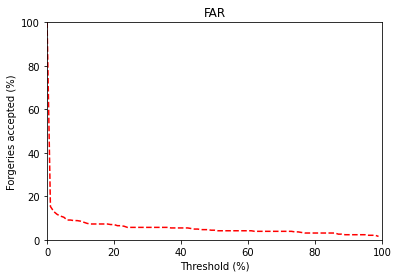

In [12]:
far = find_far(model, num_users)
print('FAR: ',far)
plt.plot(far,'--r')
plt.xlabel('Threshold (%)')
plt.ylabel('Forgeries accepted (%)')
plt.title('FAR')
plt.axis([0, 100, 0, 100])
plt.show()

### FRR

FRR:  [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.77922078  1.03896104  1.03896104
  1.03896104  1.2987013   1.2987013   1.55844156  1.55844156  1.55844156
  1.55844156  1.55844156  1.55844156  1.55844156  1.81818182  2.07792208
  2.07792208  2.07792208  2.07792208  2.07792208  2.07792208  2.33766234
  3.11688312  3.11688312  3.37662338  3.63636364  3.8961039   4.15584416
  4.15584416  4.15584416  4.15584416  4.15584416  4.15584416  5.19480519
  5.19480519  5.71428571  5.71428571

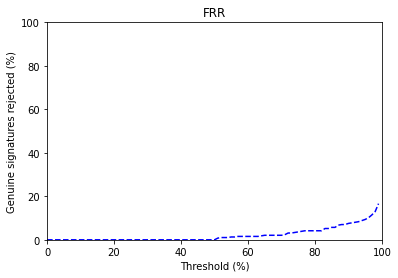

In [76]:
frr = find_frr(model, num_users)
print('FRR: ',frr)
plt.plot(frr,'--b')
plt.xlabel('Threshold (%)')
plt.ylabel('Genuine signatures rejected (%)')
plt.title('FRR')
plt.axis([0, 100, 0, 100])
plt.show()

###EER

In [13]:
EER = 0
threshold = [idx for idx in range(100)]
threshold = np.array(threshold)
# calculate the EER
try:
  idx = int(np.argwhere(np.diff(np.sign(far - frr))).flatten())
except:
  #idx = round(np.mean(np.argwhere(np.diff(np.sign(far - frr))).flatten()))
  idx = np.argwhere(np.diff(np.sign(far - frr))).flatten()[-1]
EER = (far[idx]+frr[idx])/2
Threshold = threshold[idx]

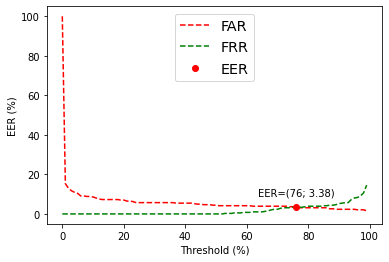

In [14]:
fig, ax = plt.subplots()
ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold (%)')
plt.ylabel('EER (%)')
plt.plot(Threshold, EER,'ro', label='EER') 
ax.text(Threshold, EER+6, f"EER=({Threshold}; {round(EER, 2)})", ha="center")

legend = ax.legend(loc='upper center', fontsize='x-large')
plt.show()